<a href="https://colab.research.google.com/github/francoisdoanp/MLTBP/blob/master/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning - Final Project**

# Turbofan engine degradation dataset (NASA)

# Data Preparation

**Importing necessary packages**



In [0]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

**Importing the Turbofan engine degradation dataset.**

**Files are located in the following Github repository: https://github.com/francoisdoanp/MLTBP**

We have 4 training datasets, which contains information about one hundred engines, all of the same type. Thus, we will combine the training and test data sets. 

The training and test sets have 21 columns: ID, Time (Cycles), 3 columns for operational settings and 21 sensor measurements.

The training and testing sets have the same format, while the validation sets only contain the real RUL (remaining useful life).

For more information on the data, consult the read me at the following address:https://github.com/francoisdoanp/MLTBP/blob/master/readme.txt

In [0]:
url_base = 'https://raw.githubusercontent.com/francoisdoanp/MLTBP/master/'

file_train_1 = 'train_FD001.txt'
file_train_2 = 'train_FD002.txt'
file_train_3 = 'train_FD003.txt'
file_train_4 = 'train_FD004.txt'

file_test_1 = 'test_FD001.txt'
file_test_2 = 'test_FD002.txt'
file_test_3 = 'test_FD003.txt'
file_test_4 = 'test_FD004.txt'

file_valid_1 = 'RUL_FD001.txt'
file_valid_2 = 'RUL_FD002.txt'
file_valid_3 = 'RUL_FD003.txt'
file_valid_4 = 'RUL_FD004.txt'


pt1 = pd.read_csv(url_base + file_train_1, sep=' ', header=None)
pt2 = pd.read_csv(url_base + file_train_2, sep=' ', header=None)
pt3 = pd.read_csv(url_base + file_train_3, sep=' ', header=None)
pt4 = pd.read_csv(url_base + file_train_4, sep=' ', header=None)

pte1 = pd.read_csv(url_base + file_test_1, sep=' ', header=None)
pte2 = pd.read_csv(url_base + file_test_2, sep=' ', header=None)
pte3 = pd.read_csv(url_base + file_test_3, sep=' ', header=None)
pte4 = pd.read_csv(url_base + file_test_4, sep=' ', header=None)

pv1 = pd.read_csv(url_base + file_valid_1, header=None)
pv2 = pd.read_csv(url_base + file_valid_2, header=None)
pv3 = pd.read_csv(url_base + file_valid_3, header=None)
pv4 = pd.read_csv(url_base + file_valid_4, header=None)


# Updating unit numbers

pt2[0] = pt2[0].apply(lambda x: x+100)
pt3[0] = pt3[0].apply(lambda x: x+360)
pt4[0] = pt4[0].apply(lambda x: x+460)

pte2[0] = pte2[0].apply(lambda x: x+100)
pte3[0] = pte3[0].apply(lambda x: x+359)
pte4[0] = pte4[0].apply(lambda x: x+459)


# Joining the dataframes

train_pd = pd.concat([pt1,pt2,pt3,pt4])
test_pd = pd.concat([pte1,pte2,pte3,pte4])
valid_pd = pd.concat([pv1,pv2,pv3,pv4])

train_pd = train_pd.drop(train_pd.columns[[26,27]], axis='columns')
test_pd = test_pd.drop(test_pd.columns[[26,27]], axis='columns')


# Assigning labels to Dataframe's columns based on the Readme

train_pd.columns = ['Unit Number', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
test_pd.columns = ['Unit Number', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
valid_pd.columns = ['RUL']

#Loading scaler

scaler = StandardScaler()
  

**Adding variables Conditons and fault mode**

Note:

**Condition (ONE)** and **Fault ONE** are binary variables.

When Condition(ONE) = 1 (true), it means that the condition is at Sea Level

When Condition(ONE) = 0 (false), it means NO, the condition IS NOT AT SEA LEVEL, and thus is the  second condition; SIX.

When Fault ONE = 1 (true), it means that the fault modes is one (HPC Degradation)

When Fault ONE = 0 (false), it means that the fault mode is TWO (HPC Degradation and Fan degradation)

In [0]:
# Adding variables Condition and fault modes

def value_condition_train(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 360) & (row['Unit Number'] > 100):
    return 0
  elif (row['Unit Number'] <= 460) & (row['Unit Number'] > 360):
    return 1
  else:
    return 0
  
def value_fault_train(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 360) & (row['Unit Number'] > 100):
    return 1
  elif (row['Unit Number'] <= 460) & (row['Unit Number'] > 360):
    return 0
  else:
    return 0
  
def value_condition_test(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 359) & (row['Unit Number'] > 100):
    return 0
  elif (row['Unit Number'] <= 459) & (row['Unit Number'] > 359):
    return 1
  else:
    return 0
  
def value_fault_test(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 359) & (row['Unit Number'] > 100):
    return 1
  elif (row['Unit Number'] <= 459) & (row['Unit Number'] > 359):
    return 0
  else:
    return 0


train_pd['Condition (One)'] = train_pd.apply(value_condition_train, axis=1)
train_pd['Fault ONE'] = train_pd.apply(value_fault_train,axis=1)

test_pd['Condition (One)'] = test_pd.apply(value_condition_test, axis=1)
test_pd['Fault ONE'] = test_pd.apply(value_fault_test,axis=1)

At this stage, we create the truth remaining useful life (RUL) for the training set.

Important note: In the training set, the last Cycle (represented in the table by 'Time (Cycles)') is when the engine is considered unusable. However, in the test set, the last cycle IS NOT when the engine is considered unusable. It will fail at a later time. Thus, in the valid_pd, we have the true RUL. 

In [0]:
#Adding column for remaining useful life (RUL)

y_train = pd.DataFrame(train_pd.groupby(['Unit Number'])['Time (Cycles)'].max())

train_pd = pd.merge(train_pd,y_train, on='Unit Number')
train_pd['RUL'] = train_pd['Time (Cycles)_y'] - train_pd['Time (Cycles)_x']
train_pd = train_pd.drop('Time (Cycles)_y',1)
train_pd = train_pd.rename(columns = {'Time (Cycles)_x':'Time (Cycles)'})

y_train = train_pd.iloc[:,28]


In [0]:
print(last_cycle)


# Data Exploration

**Now that we have our data, we can get to know our dataset**

In [21]:
display(train_pd.head())

display(test_pd.head())


print(f'The training dataset contains {train_pd.shape[0]} rows.')


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,Condition (One),Fault ONE,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,1,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,1,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,1,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,1,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,1,187


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,Condition (One),Fault ONE
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,1,1
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,1,1
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,1,1
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,1,1
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,1,1


The training dataset contains 160359 rows.


In [0]:
# Print out a table with count, mean, std, min, max, 25%, 50%, 75%

print(train_pd.describe())

**Exploring the effects of sensors on RUL**



In [0]:


print(sns.heatmap(train_pd.corr(), annot=True, cmap='RdYlGn'))

train_pd.corr()

In [0]:
print()

**Exploring correlation between variables**

In [0]:
corr = train_pd.groupby(['RUL']).corr()
corr.style.background_gradient(cmap='coolwarm')

**How do we know when an engine fails?**

We look at the last time cycle for every unit number.



Text(0, 0.5, 'Frequency')

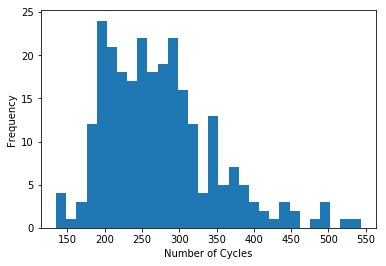

In [0]:
train_df.groupby(['Unit Number'])['Time (Cycles)'].max().hist(bins=30, grid=False)
plt.xlabel('Number of Cycles')
plt.ylabel('Frequency')


#**Model 1: Multiple Linear Regression (Not time-sensitive)**






**Preparing data**

In [0]:
# Scaling data

train_pd_scaled = train_pd.copy()
train_pd_scaled.iloc[:,2:26] = scaler.fit_transform(train_pd.iloc[:,2:26])

test_pd_lm = test_pd.copy()
test_pd_lm.iloc[:,2:26] = scaler.fit_transform(test_pd.iloc[:,2:26])

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)



In [0]:
# Removing RUL and Unit Number columns, as we do not want these features to be in our predictors

train_pd_lm = train_pd_scaled.copy()
train_pd_lm = train_pd_lm.drop(['RUL', 'Unit Number'],axis=1)

# Keeping only last time cycle for each unit number

idx = test_pd_lm.groupby(['Unit Number'])['Time (Cycles)'].transform(max) == test_pd_lm['Time (Cycles)']
test_pd_lm = test_pd_scaled[idx]

# Removing Unit Number column

test_pd_lm = test_pd_lm.drop(['Unit Number'], axis=1)

**Fitting Linear Model**

In [60]:
# Fitting Linear model

reg = LinearRegression().fit(train_pd_lm, y_train)

y_pred = reg.predict(test_pd_lm)

acc_score_lm =  metrics.mean_squared_error(valid_pd, y_pred)

print(y_pred)

print(acc_score_lm)


[ 116.29521072   72.0597518     8.1923775    29.04311473   47.89760717
   56.74631895   43.10412789   16.10395563   69.92971833   24.11641437
   45.0822937    10.60583714   10.02280448   69.98809577  100.32049795
   73.55716108    4.39025067   -0.45059654   51.82467574  -58.12718171
   44.13528716   97.06006449   79.48820297  -22.56571164   90.17801899
   89.41658854   51.94563834   25.4811307    48.78225504   23.16527715
  -42.20748619   29.91968378   70.4005692   -77.74039698  -72.84123495
  -13.57509805   15.9299959    18.38075736  118.8920907   -24.52545583
   20.38222739  -29.17868428    3.3759494    73.88994227   12.24942363
    5.51342528   81.47296203   54.33198802 -106.34162731   79.67169901
   40.48333329  -20.16014486  -20.94671614   82.94360259   69.69296242
  -23.14115573   25.14959888  -17.2736549   115.80391078   34.74970633
  -21.99587329  -12.13983733    3.41377804  -12.38536708  123.14743323
  -43.48176302   87.00988099  -64.70018244   84.60325561   24.35371594
   95.

In [0]:
__